In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Set plotting style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

columns_to_keep = [
        "Timestamp",
        "spot_close",
        "perp_close",
        "funding_rate",
        "funding_annualized",
        "prompt_close",
        "prompt_days_till_expiry",
    ]

# Load data
print("Loading market data...")
df = pd.read_csv("../binance_data_pipeline/data/markets/BTCUSDT_1d.csv", usecols=columns_to_keep)
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Filter data to the relevant time period where we have futures data
df = df[(df["Timestamp"] >= "2023-06-25") & (df["Timestamp"] < "2025-03-10")]

print(
    f"Data loaded with {len(df)} rows from {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}"
)

df['funding_rate_payment'] = df['funding_rate'] * 3
df['funding_annualized'] = df['funding_annualized'] * 100

# Display a sample of the data
df.head()

Loading market data...
Data loaded with 624 rows from 2023-06-25 to 2025-03-09


,Timestamp,spot_close,perp_close,funding_rate,funding_annualized,prompt_close,prompt_days_till_expiry,funding_rate_payment
24,2023-06-25,30462.66,30458.0,0.000100,10.95000,30880.3,96.333333,0.000300
25,2023-06-26,30267.99,30260.1,0.000100,10.95000,30688.1,95.333333,0.000300
26,2023-06-27,30692.44,30683.2,0.000100,10.95000,31201.8,94.333333,0.000300
27,2023-06-28,30077.41,30066.3,0.000080,8.72350,30574.8,93.333333,0.000239
28,2023-06-29,30447.31,30439.9,0.000086,9.44401,30998.1,92.333333,0.000259


In [13]:
# Step 1: Data Preprocessing and Metric Calculation
print("\n--- Step 1: Computing Key Metrics ---")

# Rename days till expiry columns
df.rename(
    columns={
        "prompt_days_till_expiry": "prompt_dte",
    },
    inplace=True,
)

# Set Binance's base interest rate (adjusted to percentage terms)
binance_rate = (
    0.0001 * 3 * 365 * 100
)

# Calculate basis for prompt futures contract
df["prompt_basis"] = df["prompt_close"] - df["spot_close"]
df["fut_perp_basis"] = df["prompt_close"] - df["perp_close"]

# Calculate APR for prompt futures contract
df["prompt_apr"] = (
    (df["prompt_basis"] / df["spot_close"]) * (365 / df["prompt_dte"]) * 100
)

# Calculate the spread between funding rate and futures premium
df["funding_prompt_spread"] = df["funding_annualized"] - df["prompt_apr"]

# Calculate z-score of the spread using 30-day rolling window
df["funding_prompt_spread_zscore"] = (
    df["funding_prompt_spread"] - df["funding_prompt_spread"].rolling(window=30).mean()
) / df["funding_prompt_spread"].rolling(window=30).std()

# Display calculated metrics
metrics_df = df[
    [
        "Timestamp",
        "spot_close",
        "perp_close",
        "prompt_close",
        "funding_annualized",
        "prompt_apr",
        "funding_prompt_spread",
        "funding_prompt_spread_zscore",
    ]
].copy()

print("Sample of calculated metrics:")
print(metrics_df.dropna().head())

df.head()


--- Step 1: Computing Key Metrics ---
Sample of calculated metrics:
    Timestamp  spot_close  perp_close  prompt_close  funding_annualized  \
53 2023-07-24    29176.50     29163.8       29579.5            8.883370   
54 2023-07-25    29228.91     29216.3       29632.4            8.789200   
55 2023-07-26    29351.96     29336.0       29763.3            9.204935   
56 2023-07-27    29222.78     29209.7       29613.9            3.592330   
57 2023-07-28    29314.14     29299.9       29703.6            7.682520   

    prompt_apr  funding_prompt_spread  funding_prompt_spread_zscore  
53    7.487462               1.395908                      0.393852  
54    7.595934               1.193266                      0.395937  
55    7.829281               1.375654                      0.499134  
56    7.593558              -4.001228                     -0.884992  
57    7.656781               0.025739                      0.240234  


,Timestamp,spot_close,perp_close,funding_rate,funding_annualized,prompt_close,prompt_dte,funding_rate_payment,prompt_basis,fut_perp_basis,prompt_apr,funding_prompt_spread,funding_prompt_spread_zscore
24,2023-06-25,30462.66,30458.0,0.000100,10.95000,30880.3,96.333333,0.000300,417.64,422.3,5.194581,5.755419,NaN
25,2023-06-26,30267.99,30260.1,0.000100,10.95000,30688.1,95.333333,0.000300,420.11,428.0,5.314073,5.635927,NaN
26,2023-06-27,30692.44,30683.2,0.000100,10.95000,31201.8,94.333333,0.000300,509.36,518.6,6.421273,4.528727,NaN
27,2023-06-28,30077.41,30066.3,0.000080,8.72350,30574.8,93.333333,0.000239,497.39,508.5,6.467147,2.256353,NaN
28,2023-06-29,30447.31,30439.9,0.000086,9.44401,30998.1,92.333333,0.000259,550.79,558.2,7.151077,2.292933,NaN



--- Step 2: Visualizing Key Metrics ---


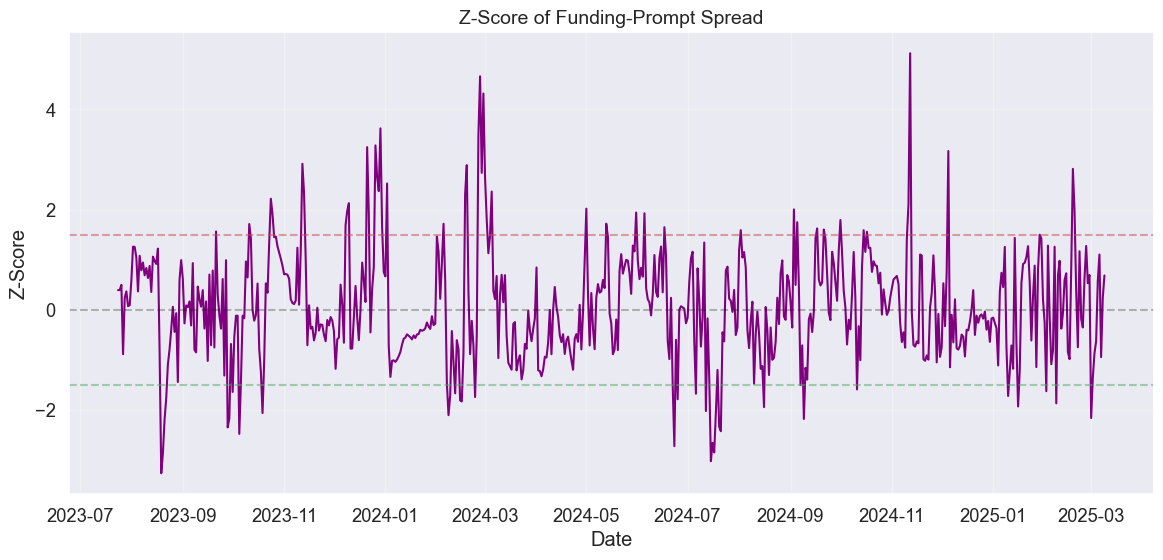

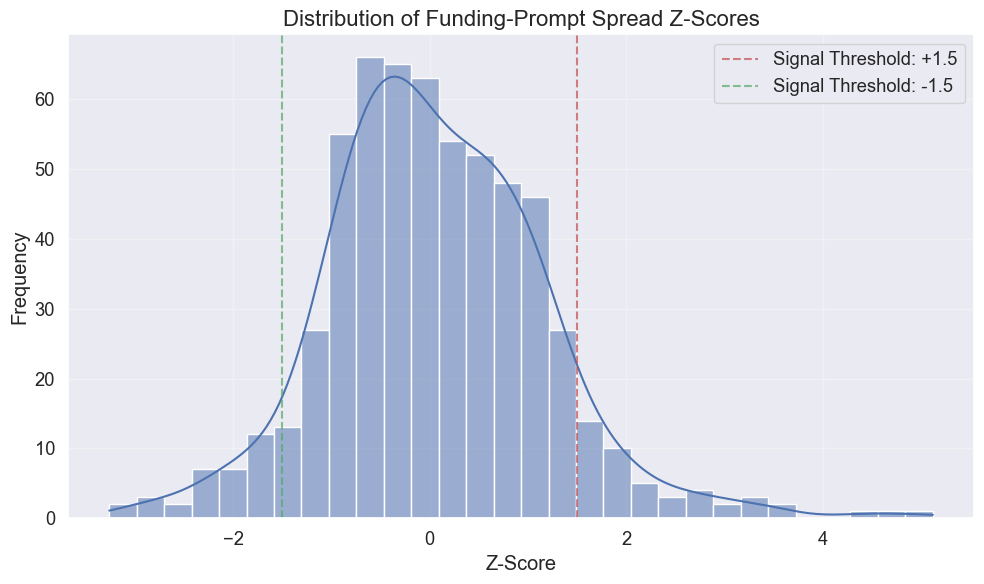

In [31]:
# Step 2: Visualize Key Metrics for Strategy Development
print("\n--- Step 2: Visualizing Key Metrics ---")

# Create a single figure
plt.figure(figsize=(14, 6))

# Plot the Z-score
plt.plot(df["Timestamp"], df["funding_prompt_spread_zscore"], "purple")

# Add reference lines
plt.axhline(y=0, color="k", linestyle="--", alpha=0.3)
plt.axhline(y=1.5, color="r", linestyle="--", alpha=0.5)
plt.axhline(y=-1.5, color="g", linestyle="--", alpha=0.5)

# Labels and title
plt.title("Z-Score of Funding-Prompt Spread", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

# Plot 3: Distribution of Spread Z-Scores
plt.figure(figsize=(10, 6))
sns.histplot(df["funding_prompt_spread_zscore"].dropna(), bins=30, kde=True)
plt.axvline(x=1.5, color="r", linestyle="--", alpha=0.7, label="Signal Threshold: +1.5")
plt.axvline(
    x=-1.5, color="g", linestyle="--", alpha=0.7, label="Signal Threshold: -1.5"
)
plt.title("Distribution of Funding-Prompt Spread Z-Scores", fontsize=16)
plt.xlabel("Z-Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:
# Step 3: Define the Trading Strategy
print("\n--- Step 3: Defining Trading Strategy ---")

# Run the strategy with default parameters
print("Running strategy backtest...")

# Generate signals
# Capture funding (short perp/long fut)
threshold = 2.0
exit_threshold = -1.0

signal_df = df.copy()
signal_df["funding_signal"] = 0  # Initialize with no positions
signal = 0  # Start with no position

# Initialize empty signal series
signals = pd.Series(None, index=signal_df.index)

# Flag entry and exit points 
signals.loc[signal_df['funding_prompt_spread_zscore'] > threshold] = 1
signals.loc[signal_df['funding_prompt_spread_zscore'] < exit_threshold] = 0
# Forward fill to maintain position state between entry and exit
signal_df['funding_signal'] = signals.ffill().fillna(0).astype(int)

signal_df.to_csv('strategy_signals.csv', index=False)
#signal_df.head()


--- Step 3: Defining Trading Strategy ---
Running strategy backtest...


In [36]:
def calculate_trade_pnl(signal_df, fee_rate=0.0004):
    """
    Calculate PnL for funding stat arb trades (short perp/long fut)
    - Calculates basis at entry/exit
    - Includes funding payments
    - Accounts for trading fees
    """
    # Set notional size and leverage
    notional_per_leg = 10000  # $10K per leg ($20K total per trade)
    leverage = 1  # Using 1x leverage
    
    # Find where signals change (funding mean reversion)
    signal_df['funding_signal_change'] = signal_df['funding_signal'].diff()
    entries = signal_df[signal_df['funding_signal_change'] == 1].index  # get trade entries
    exits = signal_df[signal_df['funding_signal_change'] == -1].index  # get trade exits

    print(f"Found funding {len(entries)} entries and {len(exits)} exits")
    if len(entries) != len(exits):
        print(f"  {len(entries) - len(exits)} trades closed at end of data window.")

    funding_trades = []
    for i, entry_idx in enumerate(entries):
        # Find corresponding exit (or use last row if position still open)
        exit_indices_after = [ex for ex in exits if ex > entry_idx]
        exit_idx = exit_indices_after[0] if len(exit_indices_after) > 0 else signal_df.index[-1]
        print(f"Processing trade {i+1}: Entry at {pd.to_datetime(signal_df.loc[entry_idx, 'Timestamp']).strftime('%Y-%m-%d')}, Exit at {pd.to_datetime(signal_df.loc[exit_idx, 'Timestamp']).strftime('%Y-%m-%d')}")

        # Get entry basis
        entry_perp = signal_df.loc[entry_idx, 'perp_close']
        entry_prompt = signal_df.loc[entry_idx, 'prompt_close']
        entry_basis = entry_perp - entry_prompt

        # Split notional
        total_notional_per_leg = notional_per_leg * leverage
        perp_contracts = total_notional_per_leg / entry_perp
        prompt_contracts = total_notional_per_leg / entry_prompt

        # Get exit basis
        exit_perp = signal_df.loc[exit_idx, 'perp_close']
        exit_prompt = signal_df.loc[exit_idx, 'prompt_close']
        exit_basis = -exit_perp + exit_prompt
        
        # Calculate price PnL (long perp, short prompt)
        perp_pnl = (exit_perp - entry_perp) * perp_contracts
        prompt_pnl = (entry_prompt - exit_prompt) * prompt_contracts
        basis_pnl = perp_pnl + prompt_pnl
        
        # Sum funding payments received during the trade
        trade_window = signal_df.loc[entry_idx:exit_idx]
        funding_pnl = trade_window['funding_rate_payment'].sum() * perp_contracts * entry_perp
        
        # Calculate trading fees
        entry_fees = total_notional_per_leg * 2 * fee_rate
        exit_fees = entry_fees
        total_fees = entry_fees + exit_fees
        
        # Total PnL
        total_pnl = basis_pnl + funding_pnl - total_fees
        
        funding_trades.append({
            'entry_date': signal_df.loc[entry_idx, 'Timestamp'],
            'exit_date': signal_df.loc[exit_idx, 'Timestamp'],
            'days_held': len(trade_window),
            'entry_perp': entry_perp,
            'entry_prompt': entry_prompt,
            'exit_perp': exit_perp,
            'exit_prompt': exit_prompt,
            'basis_pnl': basis_pnl,
            'funding_pnl': funding_pnl,
            'fees': total_fees,
            'total_pnl': total_pnl
        })
    
    result_df = pd.DataFrame(funding_trades)
    
    # Handle empty DataFrame case
    if result_df.empty:
        print("No funding trades found!")
        return pd.DataFrame(columns=['entry_date', 'exit_date', 'days_held', 'entry_perp', 
                                    'entry_prompt', 'exit_perp', 'exit_prompt', 'basis_pnl', 
                                    'funding_pnl', 'fees', 'total_pnl'])
    
    return result_df

# Usage:
trades_df = calculate_trade_pnl(signal_df)

# Handle possible empty DataFrame
if trades_df.empty:
    print("No trades to analyze")
else:
    # Calculate the sums for each component
    sums = {
        'basis_pnl': trades_df['basis_pnl'].sum(),  # Assuming renamed from price_pnl
        'funding_pnl': trades_df['funding_pnl'].sum(),
        'fees': trades_df['fees'].sum(),
        'total_pnl': trades_df['total_pnl'].sum()
    }
    
    print(f"Total PnL: {trades_df['total_pnl'].sum()}")
    # Print the results in a readable format
    print("\nPerformance Summary ($):")
    print(f"Basis PnL:    ${sums['basis_pnl']:.2f}")
    print(f"Funding PnL:  ${sums['funding_pnl']:.2f}")
    print(f"Total Fees:   ${sums['fees']:.2f}")
    print(f"Total PnL:    ${sums['total_pnl']:.2f}")
    print(f"Profit Ratio: {(sums['basis_pnl'] + sums['funding_pnl']) / sums['fees']:.2f}x")

    
trades_df.to_csv('funding_trades_df.csv', index=False)

Found funding 9 entries and 9 exits
Processing trade 1: Entry at 2023-10-24, Exit at 2023-12-02
Processing trade 2: Entry at 2023-12-10, Exit at 2024-01-04
Processing trade 3: Entry at 2024-02-18, Exit at 2024-02-24
Processing trade 4: Entry at 2024-02-26, Exit at 2024-03-15
Processing trade 5: Entry at 2024-05-01, Exit at 2024-06-22
Processing trade 6: Entry at 2024-09-03, Exit at 2024-09-07
Processing trade 7: Entry at 2024-11-11, Exit at 2024-11-21
Processing trade 8: Entry at 2024-12-05, Exit at 2024-12-06
Processing trade 9: Entry at 2025-02-18, Exit at 2025-03-01
Total PnL: 317.4391880366315

Performance Summary ($):
Basis PnL:    $-346.49
Funding PnL:  $807.93
Total Fees:   $144.00
Total PnL:    $317.44
Profit Ratio: 3.20x


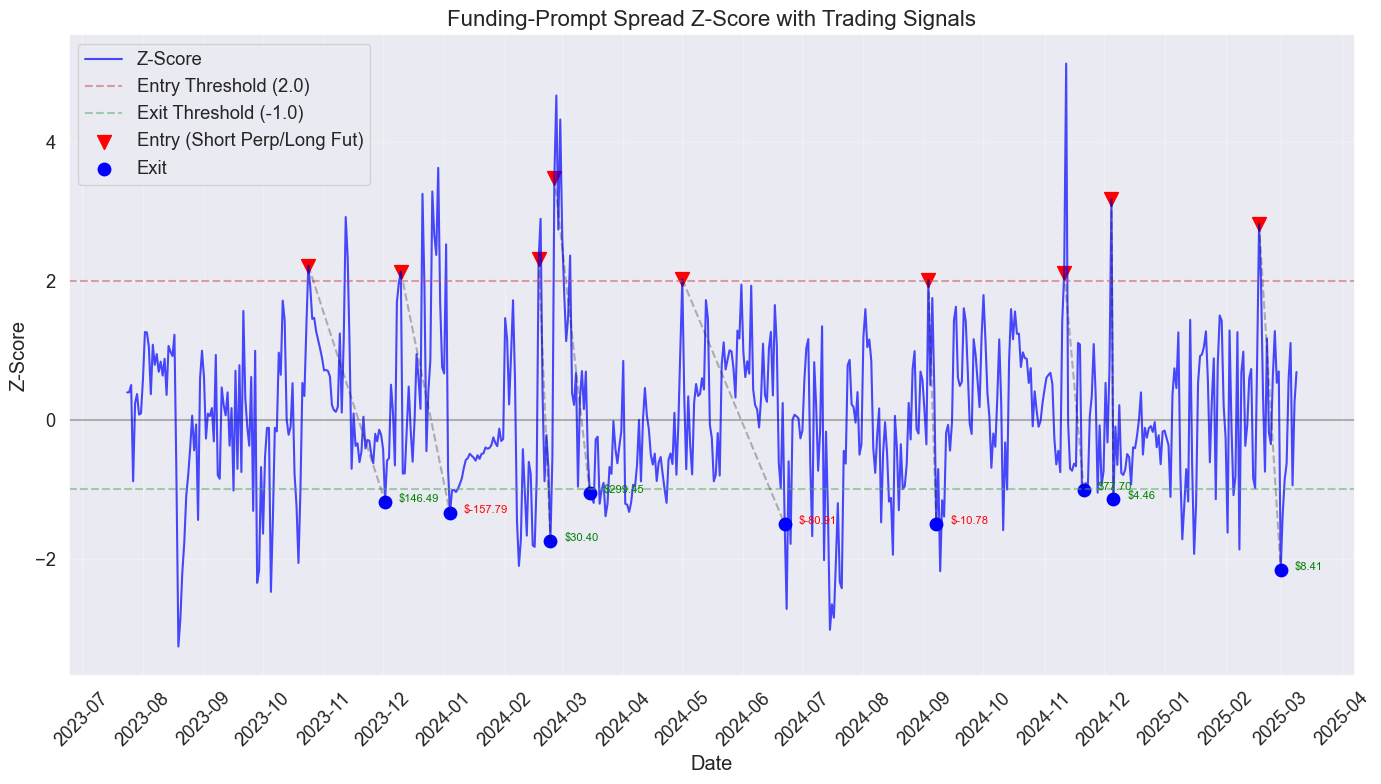

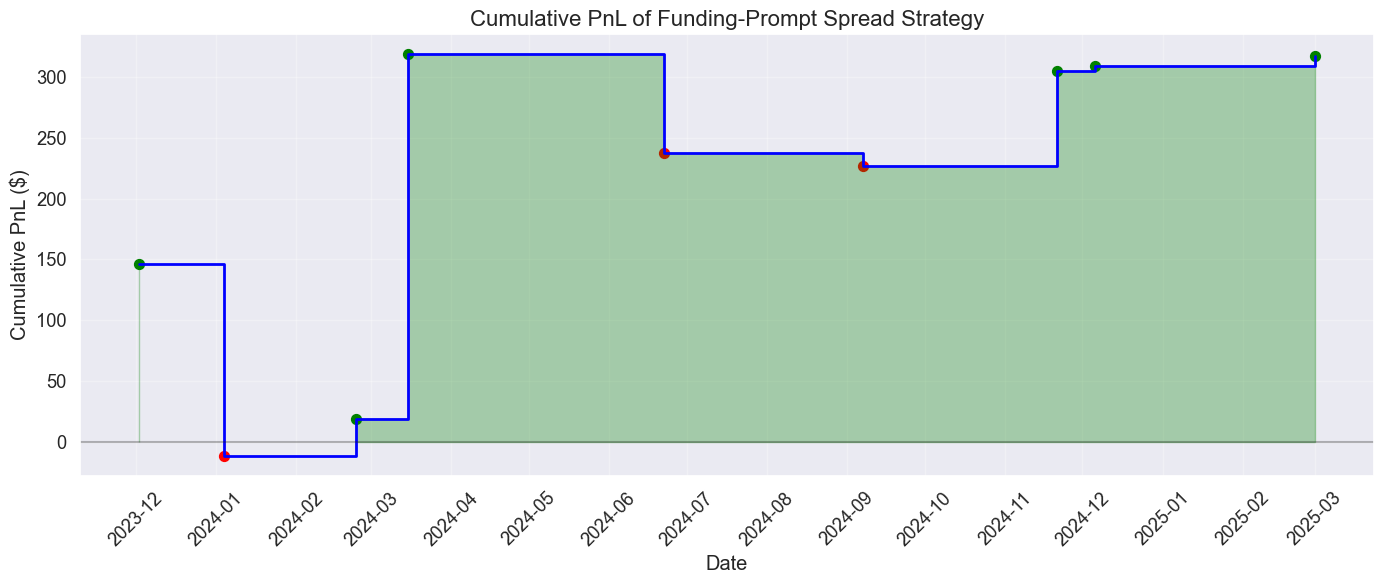


Strategy Performance Summary:
Total PnL:      $317.44
Number of Trades: 9
Win Rate:       66.7%
Average Win:    $94.48
Average Loss:   $-83.16
Profit Factor:  2.27
Max Drawdown:   $157.79


In [37]:
# Visualize funding trades on z-score chart (similar to Chart #7 in 8h_1d.ipynb)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Load the trades data
trades_df = pd.read_csv('funding_trades_df.csv')
trades_df['entry_date'] = pd.to_datetime(trades_df['entry_date'])
trades_df['exit_date'] = pd.to_datetime(trades_df['exit_date'])

# Create figure for Z-score with trading signals
plt.figure(figsize=(14, 8))

# Plot z-score of the spread
plt.plot(df['Timestamp'], df['funding_prompt_spread_zscore'], color='blue', alpha=0.7, label='Z-Score')

# Add threshold lines
threshold = 2.0
exit_threshold = -1.0
plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5, label=f'Entry Threshold ({threshold})')
plt.axhline(y=exit_threshold, color='g', linestyle='--', alpha=0.5, label=f'Exit Threshold ({exit_threshold})')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# Plot trade entry and exit points
for i, trade in trades_df.iterrows():
    # Find closest points in the df DataFrame to the trade dates
    entry_idx = np.argmin(np.abs(df['Timestamp'] - trade['entry_date']))
    exit_idx = np.argmin(np.abs(df['Timestamp'] - trade['exit_date']))
    
    entry_zscore = df.iloc[entry_idx]['funding_prompt_spread_zscore']
    exit_zscore = df.iloc[exit_idx]['funding_prompt_spread_zscore']
    
    # Plot entry point (red triangle down for short perp/long fut at high z-score)
    plt.scatter(df.iloc[entry_idx]['Timestamp'], entry_zscore, 
               color='red', marker='v', s=100, 
               label='Entry (Short Perp/Long Fut)' if i == 0 else "")
    
    # Plot exit point
    plt.scatter(df.iloc[exit_idx]['Timestamp'], exit_zscore,
               color='blue', marker='o', s=80, 
               label='Exit' if i == 0 else "")
    
    # Connect entry and exit with a line
    plt.plot([df.iloc[entry_idx]['Timestamp'], df.iloc[exit_idx]['Timestamp']], 
            [entry_zscore, exit_zscore], 'k--', alpha=0.3)
    
    # Annotate with trade PnL
    pnl_color = 'green' if trade['total_pnl'] > 0 else 'red'
    plt.annotate(f"${trade['total_pnl']:.2f}", 
                xy=(df.iloc[exit_idx]['Timestamp'], exit_zscore),
                xytext=(10, 0), textcoords='offset points',
                fontsize=8, color=pnl_color)

# Add labels and formatting
plt.title('Funding-Prompt Spread Z-Score with Trading Signals', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Create a second chart showing cumulative PnL
plt.figure(figsize=(14, 6))

# Sort trades by exit date and calculate cumulative PnL
trades_df = trades_df.sort_values('exit_date')
trades_df['cum_pnl'] = trades_df['total_pnl'].cumsum()

# Plot cumulative PnL at exit points
plt.step(trades_df['exit_date'], trades_df['cum_pnl'], where='post', color='blue', linewidth=2)

# Mark each trade exit with a point
for i, trade in trades_df.iterrows():
    marker_color = 'green' if trade['total_pnl'] > 0 else 'red'
    plt.scatter(trade['exit_date'], trade['cum_pnl'], color=marker_color, s=50)

# Fill between line and 0
plt.fill_between(trades_df['exit_date'], 0, trades_df['cum_pnl'], step='post',
                 alpha=0.3, color='green', where=(trades_df['cum_pnl'] >= 0))
plt.fill_between(trades_df['exit_date'], 0, trades_df['cum_pnl'], step='post',
                 alpha=0.3, color='red', where=(trades_df['cum_pnl'] < 0))

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Cumulative PnL of Funding-Prompt Spread Strategy', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate key performance metrics
total_pnl = trades_df['total_pnl'].sum()
num_trades = len(trades_df)
win_rate = (trades_df['total_pnl'] > 0).mean() * 100
avg_win = trades_df.loc[trades_df['total_pnl'] > 0, 'total_pnl'].mean()
avg_loss = trades_df.loc[trades_df['total_pnl'] < 0, 'total_pnl'].mean()
max_drawdown = (trades_df['cum_pnl'].cummax() - trades_df['cum_pnl']).max()

print("\nStrategy Performance Summary:")
print(f"Total PnL:      ${total_pnl:.2f}")
print(f"Number of Trades: {num_trades}")
print(f"Win Rate:       {win_rate:.1f}%")
print(f"Average Win:    ${avg_win:.2f}")
print(f"Average Loss:   ${avg_loss:.2f}" if not np.isnan(avg_loss) else "Average Loss:   $0.00")
print(f"Profit Factor:  {abs(avg_win * (trades_df['total_pnl'] > 0).sum() / (avg_loss * (trades_df['total_pnl'] < 0).sum())):.2f}" if not np.isnan(avg_loss) and (trades_df['total_pnl'] < 0).sum() > 0 else "Profit Factor:  ∞")
print(f"Max Drawdown:   ${max_drawdown:.2f}")

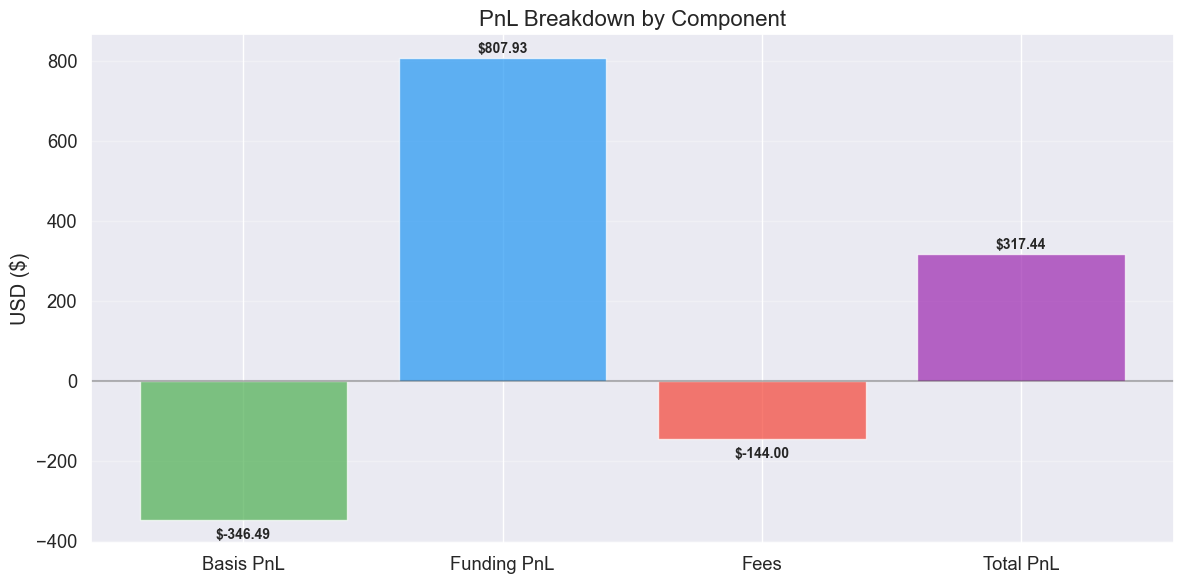

In [40]:
# Add enhanced trading statistics analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Ensure trades are sorted by exit date
trades_df = trades_df.sort_values('exit_date')

# 1. PnL Component Analysis
# Calculate total for each component
total_basis_pnl = trades_df['basis_pnl'].sum()
total_funding_pnl = trades_df['funding_pnl'].sum()
total_fees = trades_df['fees'].sum()
total_pnl = trades_df['total_pnl'].sum()

# Create PnL component breakdown chart
plt.figure(figsize=(12, 6))
components = ['Basis PnL', 'Funding PnL', 'Fees', 'Total PnL']
values = [total_basis_pnl, total_funding_pnl, -total_fees, total_pnl]  # Negate fees for visualization
colors = ['#4CAF50', '#2196F3', '#F44336', '#9C27B0']  # Green, Blue, Red, Purple

# Create bar chart with enhanced styling
ax = plt.bar(components, values, color=colors, alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(values):
    plt.text(i, v + (5 if v > 0 else -20), f'${v:.2f}', 
             ha='center', va='bottom' if v > 0 else 'top', 
             fontweight='bold', fontsize=10)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('PnL Breakdown by Component', fontsize=16)
plt.ylabel('USD ($)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



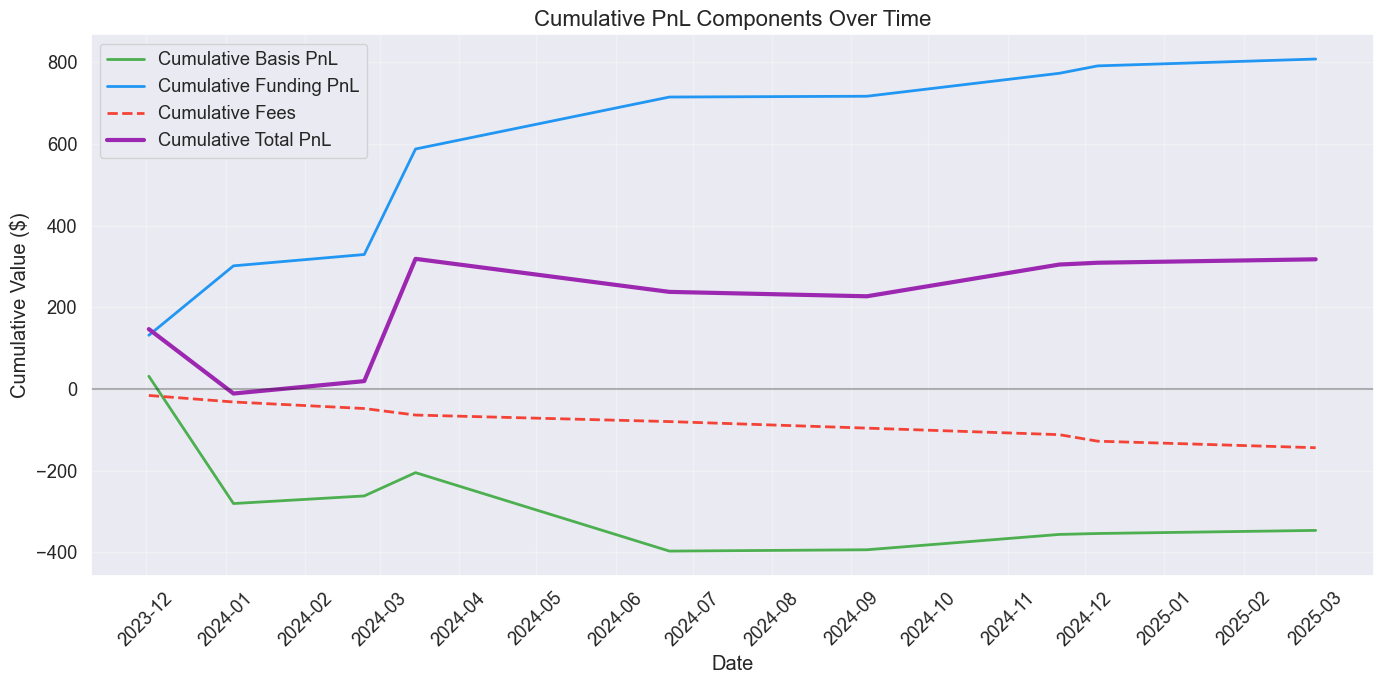

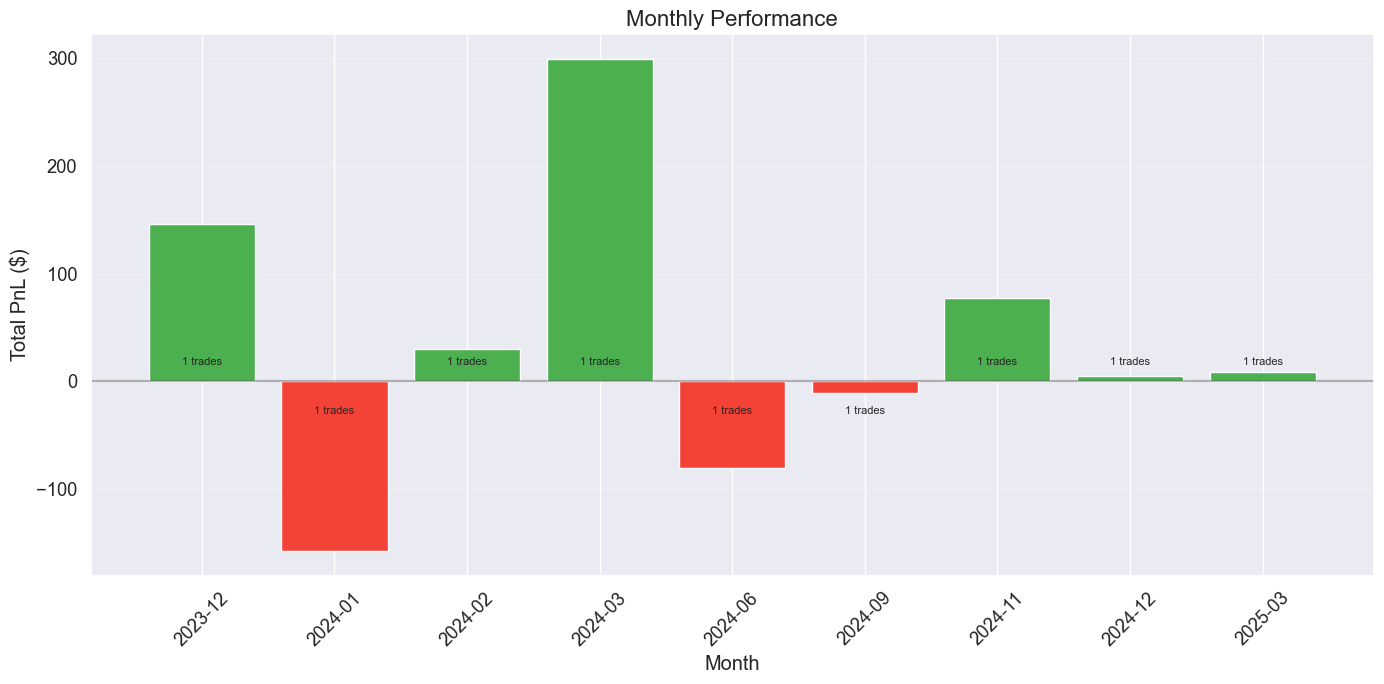


Enhanced Performance Metrics:
Trading Period:      2023-10-24 to 2025-03-01 (494 days)
Annualized Return:  1.17%
PnL per Day Held:   $1.81
Avg Trade Duration: 19.4 days
Win/Loss Ratio:     1.14
Basis/Funding Ratio: -0.43

PnL Component Breakdown:
Basis PnL:    $-346.49 (-75.1% of gross profit)
Funding PnL:  $807.93 (175.1% of gross profit)
Trading Fees: $144.00 (45.4% of net profit)
Fee Efficiency: 3.20x (gross profit / fees)


In [43]:
# 3. PnL and Component Evolution Over Time
# Calculate cumulative components
trades_df['cum_basis_pnl'] = trades_df['basis_pnl'].cumsum()
trades_df['cum_funding_pnl'] = trades_df['funding_pnl'].cumsum()
trades_df['cum_fees'] = trades_df['fees'].cumsum()

plt.figure(figsize=(14, 7))
plt.plot(trades_df['exit_date'], trades_df['cum_basis_pnl'], label='Cumulative Basis PnL', color='#4CAF50', linewidth=2)
plt.plot(trades_df['exit_date'], trades_df['cum_funding_pnl'], label='Cumulative Funding PnL', color='#2196F3', linewidth=2)
plt.plot(trades_df['exit_date'], -trades_df['cum_fees'], label='Cumulative Fees', color='#F44336', linewidth=2, linestyle='--')
plt.plot(trades_df['exit_date'], trades_df['cum_pnl'], label='Cumulative Total PnL', color='#9C27B0', linewidth=3)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Cumulative PnL Components Over Time', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Cumulative Value ($)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Monthly Performance
# Add month column
trades_df['month'] = trades_df['exit_date'].dt.strftime('%Y-%m')

# Group by month and calculate performance
monthly_performance = trades_df.groupby('month').agg({
    'total_pnl': 'sum',
    'basis_pnl': 'sum',
    'funding_pnl': 'sum',
    'fees': 'sum',
    'days_held': ['sum', 'count']  # Sum of days and count of trades
}).reset_index()

# Calculate additional metrics
monthly_performance['avg_duration'] = monthly_performance[('days_held', 'sum')] / monthly_performance[('days_held', 'count')]
monthly_performance['trades_per_month'] = monthly_performance[('days_held', 'count')]

# Plot monthly PnL
plt.figure(figsize=(14, 7))
bars = plt.bar(monthly_performance['month'], monthly_performance[('total_pnl', 'sum')], 
       color=[('#4CAF50' if x > 0 else '#F44336') for x in monthly_performance[('total_pnl', 'sum')]])

# Add trade count annotations
for i, bar in enumerate(bars):
    count = monthly_performance['trades_per_month'].iloc[i]
    plt.annotate(f'{count} trades', 
                xy=(bar.get_x() + bar.get_width()/2, 0),
                xytext=(0, 10 if monthly_performance[('total_pnl', 'sum')].iloc[i] >= 0 else -25),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=8)

plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.title('Monthly Performance', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total PnL ($)')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 5. Calculate additional performance metrics
total_days = (trades_df['exit_date'].max() - trades_df['entry_date'].min()).days
if total_days > 0:
    # Annualized return (simple)
    starting_capital = 20000  # Assuming $10K per leg, $20K total per trade
    annualized_return = (total_pnl / starting_capital) * (365 / total_days) * 100
    
    # Average trade duration
    avg_duration = trades_df['days_held'].mean()
    
    # PnL per day held
    pnl_per_day = total_pnl / trades_df['days_held'].sum()
    
    # Win/loss ratio
    if (trades_df['total_pnl'] < 0).sum() > 0:
        win_loss_ratio = avg_win / abs(avg_loss)
    else:
        win_loss_ratio = float('inf')
    
    # Calculate basis/funding ratio
    if total_funding_pnl != 0:
        basis_funding_ratio = total_basis_pnl / total_funding_pnl
    else:
        basis_funding_ratio = float('inf')
    
    # Display enhanced metrics
    print("\nEnhanced Performance Metrics:")
    print(f"Trading Period:      {trades_df['entry_date'].min().strftime('%Y-%m-%d')} to {trades_df['exit_date'].max().strftime('%Y-%m-%d')} ({total_days} days)")
    print(f"Annualized Return:  {annualized_return:.2f}%")
    print(f"PnL per Day Held:   ${pnl_per_day:.2f}")
    print(f"Avg Trade Duration: {avg_duration:.1f} days")
    print(f"Win/Loss Ratio:     {win_loss_ratio:.2f}")
    print(f"Basis/Funding Ratio: {basis_funding_ratio:.2f}")
    
    # Component breakdown
    print("\nPnL Component Breakdown:")
    print(f"Basis PnL:    ${total_basis_pnl:.2f} ({(total_basis_pnl/(total_basis_pnl+total_funding_pnl)*100):.1f}% of gross profit)")
    print(f"Funding PnL:  ${total_funding_pnl:.2f} ({(total_funding_pnl/(total_basis_pnl+total_funding_pnl)*100):.1f}% of gross profit)")
    print(f"Trading Fees: ${total_fees:.2f} ({(total_fees/total_pnl*100):.1f}% of net profit)")
    
    # Fee efficiency
    print(f"Fee Efficiency: {(total_basis_pnl + total_funding_pnl) / total_fees:.2f}x (gross profit / fees)")

In [44]:
# Calculate risk-adjusted performance metrics (Sharpe, APR, etc.)
import pandas as pd
import numpy as np
from datetime import timedelta

# Parameters
initial_capital = 20000  # Assuming $10K per leg, $20K total per trade
risk_free_rate = 0.04  # 4% annual risk-free rate

# Create a daily P&L series
# First, get the full date range of trading
start_date = trades_df['entry_date'].min()
end_date = trades_df['exit_date'].max()
date_range = pd.date_range(start=start_date, end=end_date)

# Create a DataFrame with all dates in the trading period
daily_pnl = pd.DataFrame(index=date_range)
daily_pnl.index.name = 'date'
daily_pnl['pnl'] = 0.0

# Assign each trade's P&L to its exit date
for _, trade in trades_df.iterrows():
    daily_pnl.loc[trade['exit_date'], 'pnl'] += trade['total_pnl']

# Calculate cumulative P&L and equity curve
daily_pnl['cum_pnl'] = daily_pnl['pnl'].cumsum()
daily_pnl['equity'] = initial_capital + daily_pnl['cum_pnl']
daily_pnl['return'] = daily_pnl['pnl'] / initial_capital
daily_pnl['cum_return'] = daily_pnl['equity'] / initial_capital - 1

# Calculate drawdowns
daily_pnl['peak'] = daily_pnl['equity'].cummax()
daily_pnl['drawdown'] = (daily_pnl['equity'] - daily_pnl['peak']) / daily_pnl['peak']

# Calculate key metrics
trading_days = len(daily_pnl)
calendar_days = (end_date - start_date).days
active_days = daily_pnl[daily_pnl['pnl'] != 0].shape[0]

# Calculate APR
total_return = daily_pnl['cum_return'].iloc[-1]
apr = ((1 + total_return) ** (365 / calendar_days) - 1) * 100

# Calculate volatility (annualized)
daily_returns_std = daily_pnl['return'].std()
annualized_vol = daily_returns_std * np.sqrt(365) * 100  # Convert to percentage

# Calculate Sharpe ratio
daily_return_avg = daily_pnl['return'].mean()
daily_rf_rate = risk_free_rate / 365
excess_return = daily_return_avg - daily_rf_rate
sharpe_ratio = excess_return / daily_returns_std * np.sqrt(365) if daily_returns_std > 0 else float('inf')

# Calculate Sortino ratio (using only negative returns)
negative_returns = daily_pnl[daily_pnl['return'] < 0]['return']
downside_deviation = negative_returns.std() * np.sqrt(365) if len(negative_returns) > 0 else 0
sortino_ratio = excess_return / (downside_deviation / np.sqrt(365)) if downside_deviation > 0 else float('inf')

# Calculate Calmar ratio
max_dd = daily_pnl['drawdown'].min() * 100  # Convert to percentage
calmar_ratio = apr / abs(max_dd) if max_dd != 0 else float('inf')

# Calculate win rate on active days
daily_pnl['win'] = daily_pnl['pnl'] > 0
win_rate_days = daily_pnl[daily_pnl['pnl'] != 0]['win'].mean() * 100 if active_days > 0 else 0

# Calculate trade metrics again for reference
num_trades = len(trades_df)
win_rate_trades = (trades_df['total_pnl'] > 0).mean() * 100
avg_trade_return = trades_df['total_pnl'].mean() / initial_capital * 100
trade_return_std = trades_df['total_pnl'].std() / initial_capital * 100

# Print results
print("\n===== RISK-ADJUSTED PERFORMANCE METRICS =====")
print(f"\nTrading Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Total Calendar Days: {calendar_days}")
print(f"Days with Trading Activity: {active_days} ({active_days/calendar_days*100:.1f}% of period)")

print("\n----- RETURNS -----")
print(f"Total Return: {total_return*100:.2f}%")
print(f"Annualized Return (APR): {apr:.2f}%")
print(f"Annualized Volatility: {annualized_vol:.2f}%")

print("\n----- RISK METRICS -----")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Calmar Ratio: {calmar_ratio:.2f}")
print(f"Maximum Drawdown: {max_dd:.2f}%")

print("\n----- CAPITAL EFFICIENCY -----")
print(f"Return on Capital: {(total_pnl/initial_capital)*100:.2f}%")
print(f"Average Trade Size: ${initial_capital:,.2f}")
print(f"Average P&L per Trade: ${trades_df['total_pnl'].mean():.2f}")
print(f"Average Return per Trade: {avg_trade_return:.2f}%")
print(f"Standard Deviation of Trade Returns: {trade_return_std:.2f}%")

# Calculate probabilistic metrics
kelly_criterion = win_rate_trades/100 - ((1-win_rate_trades/100)/(avg_win/abs(avg_loss))) if not np.isnan(avg_loss) and avg_loss != 0 else 1.0

print("\n----- PROBABILISTIC METRICS -----")
print(f"Win Rate (Trades): {win_rate_trades:.1f}%")
print(f"Win Rate (Active Days): {win_rate_days:.1f}%")
print(f"Profit Factor: {abs(trades_df[trades_df['total_pnl'] > 0]['total_pnl'].sum() / trades_df[trades_df['total_pnl'] < 0]['total_pnl'].sum()):.2f}" if (trades_df['total_pnl'] < 0).sum() > 0 else "Profit Factor: ∞")
print(f"Kelly Criterion: {kelly_criterion:.2f}")
print(f"Half Kelly (Recommended Position Size): {kelly_criterion/2:.2f}")

# Calculate turnover and exposure
total_traded_volume = (trades_df['entry_perp'] * initial_capital / 2).sum() + (trades_df['entry_prompt'] * initial_capital / 2).sum()
annualized_turnover = total_traded_volume / initial_capital * (365 / calendar_days)

# Calculate average exposure
average_daily_exposure = num_trades * initial_capital * np.mean(trades_df['days_held']) / calendar_days

print("\n----- TRADING ACTIVITY -----")
print(f"Number of Trades: {num_trades}")
print(f"Average Trade Duration: {trades_df['days_held'].mean():.1f} days")
print(f"Trade Frequency: {num_trades/(calendar_days/365):.1f} trades per year")
print(f"Annualized Turnover: {annualized_turnover:.2f}x")
print(f"Average Daily Exposure: ${average_daily_exposure:,.2f} ({average_daily_exposure/initial_capital*100:.1f}% of capital)")

# Calculate correlation with BTC
if 'spot_close' in df.columns:
    # Get BTC prices
    df_for_corr = df[['Timestamp', 'spot_close']].copy()
    df_for_corr.set_index('Timestamp', inplace=True)
    
    # Resample to daily and calculate returns
    btc_daily = df_for_corr.resample('D').last()
    btc_daily['return'] = btc_daily['spot_close'].pct_change()
    
    # Align with strategy returns
    aligned_returns = pd.merge(
        daily_pnl['return'], 
        btc_daily['return'],
        left_index=True, 
        right_index=True,
        how='inner',
        suffixes=('_strat', '_btc')
    )
    
    # Calculate correlation
    correlation = aligned_returns.corr().iloc[0, 1]
    
    print("\n----- MARKET CORRELATION -----")
    print(f"Correlation with BTC: {correlation:.2f}")
    
    # Calculate beta
    strat_var = aligned_returns['return_strat'].var()
    btc_var = aligned_returns['return_btc'].var()
    beta = correlation * (np.sqrt(strat_var) / np.sqrt(btc_var)) if btc_var > 0 else 0
    
    print(f"Beta to BTC: {beta:.2f}")


===== RISK-ADJUSTED PERFORMANCE METRICS =====

Trading Period: 2023-10-24 to 2025-03-01
Total Calendar Days: 494
Days with Trading Activity: 9 (1.8% of period)

----- RETURNS -----
Total Return: 1.59%
Annualized Return (APR): 1.17%
Annualized Volatility: 1.66%

----- RISK METRICS -----
Sharpe Ratio: -1.70
Sortino Ratio: -0.02
Calmar Ratio: 1.49
Maximum Drawdown: -0.78%

----- CAPITAL EFFICIENCY -----
Return on Capital: 1.59%
Average Trade Size: $20,000.00
Average P&L per Trade: $35.27
Average Return per Trade: 0.18%
Standard Deviation of Trade Returns: 0.66%

----- PROBABILISTIC METRICS -----
Win Rate (Trades): 66.7%
Win Rate (Active Days): 66.7%
Profit Factor: 2.27
Kelly Criterion: 0.37
Half Kelly (Recommended Position Size): 0.19

----- TRADING ACTIVITY -----
Number of Trades: 9
Average Trade Duration: 19.4 days
Trade Frequency: 6.6 trades per year
Annualized Turnover: 432185.12x
Average Daily Exposure: $7,085.02 (35.4% of capital)

----- MARKET CORRELATION -----
Correlation with BT